- Read CVDP monthly nino34 of whole datasets
- Detrend dataset using 30-year rolling average
- Create nino DataFrame
- SST composit
- U500/V500
- U200/V200

- original CVDP output files /glade/campaign/cesm/development/cvcwg/cvwg/CVDP-LE_Data_Repository
- cesm-lens_1920-2100.cvdp_data.tar 

In [2]:
import glob
import os
import datetime
import pandas as pd
from datetime import datetime
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
def create_nino_df(df_nino34_detrend, year_s, year_e, t_delta):
    '''
    From LENS2 nino34 dataframe create an El Nino 1, La Nina:-1, normoal:0 dataframe 
    1) pick data between year_s and Jan year_e + 1 (because of 6 month average)
    2) assign 0, 1, -1 according to nino34 index
    
    df_nino34_detrend: original detrended nino34 dataframe
    t_delta: El Nino  critirea
    df_nino34_c_01: return El Nino 1, La Nino:-1, normoal:0 dataframe from nino34 dataframe
    '''

    # slide data between year_s and year_e (start and end year)
    aa = df_nino34_detrend[df_nino34_detrend.index>=pd.to_datetime(datetime(year_s, 1, 1,0)) ]  
    df_nino34_c = aa[aa.index<=pd.to_datetime(datetime(year_e+1, 1, 31,0)) ]    
    df_nino34_c_00 = df_nino34_c.copy()

    # not El Nino 0
    df_nino34_c_01 = df_nino34_c_00.where(df_nino34_c_00 > t_delta, 0)
    
    #  El Nino: 1
    df_nino34_c_01 = df_nino34_c_01.where(df_nino34_c_01==0, 1)
    
    # La Nina : -1 
    df_nino34_c_01 = df_nino34_c_01.where(df_nino34_c_00>=(t_delta*(-1)), -1)
    
    return df_nino34_c_01


In [4]:
def cal_nino_Aug_annual(df_nino34_c_01):
    '''
    from LENS2 nino 0-1 datafram df_nino34_c_01, get check El Nino, La Nino Year of Aug.
    check El Nino, La Nino Year of Aug. 
    when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.
    return dataFrame df_nino((n_mem, n_year)) of each Aug ( El Nino 1, La Nino:-1, normoal:0)
    '''

    # because of 6-month nino34 requirement, 
    # for Aug, it starts from March and end Jan next year
    month_s = 3
    month_e = 8
    year_s = df_nino34_c_01.index.year[0]
    #  note: started Aug for 6 months, data ended in next Jan
    year_e = df_nino34_c_01.index.year[-2]
    
    n_year = int(len(df_nino34_c_01)/12)
    n_mem = df_nino34_c_01.shape[1]
    
    # return array: El Nino:1, nomal:0, La Nino:-1
    nino_2d = np.zeros((n_mem, n_year))
    n_month_work = 6 # from March to Aug
    
    for year in range(year_s, year_e + 1):
        # for Aug -1 or 1 for a period of 6 months or more 
        date_s = datetime(year,   month_s,  1, 0)
        date_e = datetime(year+1, 1,        31, 0)
        date_i = pd.date_range(date_s, end=date_e, freq='m')
     
        df_work = df_nino34_c_01.loc[date_i]
        for nm in range(n_mem):
            tmp = df_work[nm+1].rolling(window=6).mean()

            # 1: El Nino  
            tmp_p = (tmp==1).astype(int)
            # -1: La Lina 
            tmp_n = (tmp==-1).astype(int)
            
            if tmp_p.any():
                nino_2d[nm, year-year_s] = 1   

            elif tmp_n.any():
                nino_2d[nm, year-year_s] = -1  

    df_nino = pd.DataFrame(np.transpose(nino_2d), columns = np.arange(1, n_mem+1), index = range(year_s, year_e + 1))
    return  df_nino       

In [5]:
def select_month_lens2(flnm, year_s, year_e, month, var_s):
    '''
    select specific month between year_s and year_e from LENS2 decadel dataset
    month: 1, Jan, 8: Aug....
    Example: sst_aug = select_month_lens2(flnm_sst, 1981, 1988, 8)
    '''
    #print(flnm) 
    ds = xr.open_dataset(flnm) 
    sst0 = ds[var_s]
         
    dStartDay = datetime(year_s, 1, 1, 0)
    dStopDay  = datetime(year_e, 12, 31, 0)
    yyyymm = pd.date_range(dStartDay, end=dStopDay, freq='m')
    # reassign time coordinate
    # orignal time coordinate use end point of time
    sst0 = sst0.assign_coords({"time": yyyymm})
 
    # select Aug
    sst_aug = sst0.sel(time = sst0.time.dt.month==month)
    return sst_aug

In [6]:
def select_monthFromDaily_lens2(flnm, var_s, year_s, year_e, month):
    '''
    select specific month between year_s and year_e from LENS2 decadel dataset
    return xarray of that month
    month: 1, Jan, 8: Aug....
    Example: u500_aug = select_monthFromDaily_lens2(flnm_sst, 1981, 1988, 8)
    '''
    #print(flnm) 
    ds = xr.open_dataset(flnm)
    data = ds[var_s]
     
    # select Aug
    var_aug = data.sel(time = data.time.dt.month==month)

    # slice daily data between years
    dStartDay = str(year_s) + "-" + str(month).zfill(2) + "-01"
    dStopDay  = str(year_e) + "-" + str(month).zfill(2) + "-31"
    var_aug_new = var_aug.sel(time=slice(dStartDay, dStopDay))

    # monthly mean (groupby year)
    var_aug = var_aug_new.groupby("time.year").mean("time")  

    # generate monthly DatetimeIndex at the end of the month    
    dStartDay = datetime(year_s, 1, 1, 0)
    dStopDay  = datetime(year_e, 12, 31, 0)
    n_st = month - 1
    yyyymm = pd.date_range(dStartDay, end=dStopDay, freq='m')[n_st::12] 

    # rename coordinate and assign new date
    var_aug = var_aug.rename({'year': 'time'})
    var_aug = var_aug.assign_coords({"time": yyyymm})
     
    return var_aug


In [7]:
def composit_monthly(dir_sst, cesm2_1d, dec_c, var_s, month):
    '''
    calculate monthly average SST of selected period
    '''
    n_dec = len(dec_c)
    n_mem = len(cesm2_1d)
    for nm in range(n_mem):
        for nd in range(n_dec):
            flnm_sst = sorted(glob.glob(dir_sst + "*" + cesm2_1d[nm] + "*" + dec_c[nd] + ".nc"))
            # select Aug from Decadel dataset
            sst_aug = select_month_lens2(flnm_sst[0], int(dec_c[nd][:4]), int(dec_c[nd][7:11]), month, var_s)
         
            # concatinate
            if nd == 0:
                sst = sst_aug
            else:
                sst = xr.concat([sst, sst_aug], dim="time")
            
        # reassign time coordinate to year        
        sst = sst.assign_coords({"time": sst.time.dt.year})  

        # select year
        if dec_c[0] == '200001-200912':
            sst_new = sst.sel(time = sst.time >= 2003)
            sst = sst_new.sel(time = sst_new.time <= 2033)
        elif  dec_c[0] == '205501-206412':
            sst_new = sst.sel(time = sst.time >= 2055)
            sst = sst_new.sel(time = sst_new.time <= 2085)
        return sst.mean(dim='time')

In [8]:
def composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_c, var_s, month):
    '''
    calculate monthly average SST of selected period
    '''
    n_dec = len(dec_c)
    n_mem = len(cesm2_1d)
    for nm in range(n_mem):
        for nd in range(n_dec):
            year_s = int(dec_c[nd][:4])
            year_e = int(dec_c[nd][9:13])
             
            flnm_1d = sorted(glob.glob(dir_var + "*" + cesm2_1d[nm] + "*" + dec_c[nd] + ".nc"))
             
            # select/calculate monthly mean from Decadel dataset
            var_aug = select_monthFromDaily_lens2(flnm_1d[0], var_s, year_s, year_e, month) 
            
            # concatinate
            if nd == 0:
                data = var_aug
            else:
                data = xr.concat([data, var_aug], dim="time")    
            
        # reassign time coordinate to year        
        data = data.assign_coords({"time": data.time.dt.year})  

        # select year
        if dec_c[0] == '200001-200912':
            data_new = sst.sel(time = data.time >= 2003)
            datat = data_new.sel(time = data_new.time <= 2033)
        elif  dec_c[0] == '205501-206412':
            data_new = sst.sel(time = data.time >= 2055)
            data = data_new.sel(time = data_new.time <= 2085)
        return data.mean(dim='time')



In [9]:
import matplotlib.patches as mpatches
def plot_nino(da, vmin, vmax, c_map):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
    ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    # Niño 3.4 (5N-5S, 170W-120W):
    ax.add_patch(mpatches.Rectangle(xy=[190, -5], width=50, height=10,
                                facecolor='None', edgecolor='k',
                                transform=ccrs.PlateCarree()))
    im = da.plot(ax=ax, transform=ccrs.PlateCarree(), 
            vmin=vmin, vmax=vmax, cmap=c_map,cbar_kwargs={'orientation': 'horizontal'})
    
    #fig.colorbar(im, orientation="horizontal", pad = 0.4)
    plt.show();


In [50]:
def plot_nino_2(da, vmin, vmax, title, color_map, is_zoom):
    nino_name = ['Future La Nina-current',  'Future El Nino-current']
    fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
        
    for nf in range(2):
        # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
        if is_zoom == 'zoomIn':
            # Hawaii 19.74, longitude is -155.84.
            # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
            ax[nf].set_extent([150, 260, -10, 30], crs=ccrs.PlateCarree())
            
        #ax[nf].set_extent([120, 280, -20, 20], crs=ccrs.PlateCarree())
        ax[nf].coastlines()
        ax[nf].gridlines()
        # Niño 3.4 (5N-5S, 170W-120W):
        ax[nf].add_patch(mpatches.Rectangle(xy=[190, -5], width=50, height=10,
                                facecolor='None', edgecolor='k',
                                transform=ccrs.PlateCarree()))
        da[nf].plot(ax=ax[nf], transform=ccrs.PlateCarree(), 
            vmin=vmin, vmax=vmax, cmap=color_map,cbar_kwargs={'orientation': 'horizontal'})

        ax[nf].title.set_text(nino_name[nf])
      
    # Set a Single Main Title for All the Subplots
    fig.suptitle(title, fontsize=15)
     

In [48]:
def plot_nino_3(da, ct_1d, vmin, vmax, title, color_map):
    nino_name = ['LaNina', 'Normal', 'ElNino']
    fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(18, 4), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    if np.all(ct_1d == 0):
        plot_type = 'dif'
    else:
        plot_type = 'act'
        
    for nf in range(3):
        # Hawaii 19.74, longitude is -155.84.
        # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
        ax[nf].set_extent([150, 260, -10, 30], crs=ccrs.PlateCarree())
        ax[nf].coastlines()
        ax[nf].gridlines()
        # Niño 3.4 (5N-5S, 170W-120W):
        ax[nf].add_patch(mpatches.Rectangle(xy=[190, -5], width=50, height=10,
                                facecolor='None', edgecolor='k',
                                transform=ccrs.PlateCarree()))
        da[nf].plot(ax=ax[nf], transform=ccrs.PlateCarree(), 
            vmin=vmin, vmax=vmax, cmap=color_map,cbar_kwargs={'orientation': 'horizontal'})

        if plot_type == 'dif':
            ax[nf].title.set_text(nino_name[nf])
        else:
            ax[nf].title.set_text(nino_name[nf] + ' ' + str(round(ct_1d[nf]/np.asarray(ct_1d).sum(),2)) + '%' )

    # Set a Single Main Title for All the Subplots
    fig.suptitle(title, fontsize=15)
    #fig.tight_layout()
    #fig.colorbar(im, orientation="horizontal", pad = 0.4)
    #plt.show();


In [133]:
def plot_nino_wind2(da, da_u, da_v, ct_1d, vmin, vmax, title, title_sub,color_map, is_zoom):
    nino_name = ['Future LaNina - current Aug', 'Future ElNino - current Aug']
    fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15, 5), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
        
    for nf in range(2):
        # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
        if is_zoom == 'zoomIn':
            # Hawaii 19.74, longitude is -155.84.
            # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
            ax[nf].set_extent([150, 260, -10, 30], crs=ccrs.PlateCarree())
         
        # Niño 3.4 (5N-5S, 170W-120W):
        ax[nf].add_patch(mpatches.Rectangle(xy=[190, -5], width=50, height=10,
                                facecolor='None', edgecolor='k' ,
                                transform=ccrs.PlateCarree()))
        
        
        da[nf].plot(ax=ax[nf], transform=ccrs.PlateCarree(), 
            vmin=vmin, vmax=vmax, cmap=color_map,cbar_kwargs={'orientation': 'horizontal'})
        
        Q = ax[nf].quiver(da.lon[::8], da.lat[::8], da_u[nf,::8,::8], da_v[nf,::8,::8], color = 'black',transform=ccrs.PlateCarree()) 
                          #,scale_u3its='xy', scale=3, width=0.002)

        # Q, X, Y, arrow length
        ax[nf].quiverkey(Q, 0.85, 0.26, 4, '4 m/s', 
                             fontproperties={'size':10},
                            labelpos='E', coordinates='figure') 

        ax[nf].coastlines()
        ax[nf].gridlines()
        
        ax[nf].title.set_text(title_sub[nf])
        
    # Set a Single Main Title for All the Subplots
    fig.suptitle(title, fontsize=18)

In [80]:
def plot_nino_wind3(da, da_u, da_v, ct_1d, vmin, vmax, title, color_map, is_zoom):
    nino_name = ['LaNina', 'Normal', 'ElNino']
    fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(18, 4), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    #fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(18, 4), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    if np.all(ct_1d == 0):
        plot_type = 'dif'
    else:
        plot_type = 'act'
        
    for nf in range(3):
        # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
        if is_zoom == 'zoomIn':
            # Hawaii 19.74, longitude is -155.84.
            # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
            ax[nf].set_extent([150, 260, -10, 30], crs=ccrs.PlateCarree())

        # Niño 3.4 (5N-5S, 170W-120W):
        ax[nf].add_patch(mpatches.Rectangle(xy=[190, -5], width=50, height=10,
                                facecolor='None', edgecolor='k' ,
                                transform=ccrs.PlateCarree()))
        
        
        da[nf].plot(ax=ax[nf], transform=ccrs.PlateCarree(), 
            vmin=vmin, vmax=vmax, cmap=color_map,cbar_kwargs={'orientation': 'horizontal'})
        
        Q = ax[nf].quiver(da.lon[::8], da.lat[::8], da_u[nf,::8,::8], da_v[nf,::8,::8], color = 'black',transform=ccrs.PlateCarree()) 
                          #,scale_units='xy', scale=3, width=0.002)
        
        ax[nf].quiverkey(Q, 0.85, 0.9, 5, '5 m/s', 
                             fontproperties={'size':18},
                            labelpos='E', coordinates='figure') 

        ax[nf].coastlines()
        ax[nf].gridlines()
        
        if plot_type == 'dif':
            ax[nf].title.set_text(nino_name[nf])
        else:
            ax[nf].title.set_text(nino_name[nf] + ' ' + str(round(ct_1d[nf]/np.asarray(ct_1d).sum(),2)) + '%' )

    # Set a Single Main Title for All the Subplots
    fig.suptitle(title, fontsize=15)



In [55]:
def plot_nino_4(da, ct_1d, vmin, vmax, title, color_map, is_zoom):
    nino_name = ['LaNina', 'Normal', 'ElNino', 'mean']

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    
    if np.all(ct_1d == 0):
        plot_type = 'dif'
    else:
        plot_type = 'act'
        
    for nr in range(2):
      for nc in range(2):
        nf = nr*2 + nc
        # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
        if is_zoom == 'zoomIn':
            # Hawaii 19.74, longitude is -155.84.
            # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
            ax[nr][nc].set_extent([150, 260, -10, 30], crs=ccrs.PlateCarree())
            
        ax[nr][nc].coastlines()
        ax[nr][nc].gridlines()
        # Niño 3.4 (5N-5S, 170W-120W):
        ax[nr, nc].add_patch(mpatches.Rectangle(xy=[190, -5], width=50, height=10,
                                facecolor='None', edgecolor='k',
                                transform=ccrs.PlateCarree()))
        da[nf].plot(ax=ax[nr][nc], transform=ccrs.PlateCarree(), 
            vmin=vmin, vmax=vmax, cmap=color_map,cbar_kwargs={'orientation': 'horizontal'})

        if plot_type == 'dif' or nf == 3:
            ax[nr, nc].title.set_text(nino_name[nf])
        else:
            ax[nr,nc].title.set_text(nino_name[nf] + ' ' + str(round(ct_1d[nf]/np.asarray(ct_1d).sum(),2)) + '%' )

    # Set a Single Main Title for All the Subplots
    fig.suptitle(title, fontsize=15)
    #fig.tight_layout()
    #fig.colorbar(im, orientation="horizontal", pad = 0.4)
    #plt.show();


In [15]:
def composit_nino(dir_sst, df_nino_c, cesm2_1d, dec_c, var_s, month):
    '''
    composited La Nino, Normal, and El Nino years
    df_nino_c: DataFrame((n_mem, n_year)) of each Aug ( El Nino 1, La Nino:-1, normoal:0)
    cesm2_1d: CESM2_LEN id: 1001.001, 1011.001 ... 1301.020
    dec_c: Decadel list ['200001-200912','201001-201412']
    var_s: variable like SST
    data_3d, ct_1d = composit_nino(dir_sst,cesm2_1d, ['200001-200912','201001-201412'], 'SST')
    '''
    n_dec = len(dec_c)
    n_mem = len(cesm2_1d)
    nino_value = [-1, 0, 1]
    nino_name = ['LaNina', 'Normal', 'ElNino']
    n_nino = len(nino_value)
    ct_1d = np.zeros((n_nino))

    for nm in range(n_mem):
        for nd in range(n_dec):
            flnm_sst = sorted(glob.glob(dir_sst + "*" + cesm2_1d[nm] + "*" + dec_c[nd] + ".nc"))
            # select Aug from Decadel dataset
            sst_aug = select_month_lens2(flnm_sst[0], int(dec_c[nd][:4]), int(dec_c[nd][7:11]), month, var_s)
         
            # concatinate
            if nd == 0:
                sst = sst_aug
            else:
                sst = xr.concat([sst, sst_aug], dim="time")
            
        # reassign time coordinate to year        
        sst = sst.assign_coords({"time": sst.time.dt.year})       

        for nn in range(n_nino):
            # select rows based on column values
            df_el = df_nino_c[nm+1].loc[df_nino_c[nm+1]==nino_value[nn]]
            ind_list = df_el.index  
    
            sst_el = sst.sel(time = ind_list)
            
            sst_sum = sst_el.sum(dim = 'time')

            # create a xarray for 0,-1, 1 3-type of SST
            if nm == 0:
                if nn == 0:
                    sst_3d = sst_sum.expand_dims(dim={"nino_type": 1})
                else:
                    sst_3d = xr.concat([sst_3d, sst_sum], dim = "nino_type")
            else:
                sst_3d[nn] =  sst_3d[nn] + sst_sum 
            
            ct_1d[nn] =  ct_1d[nn] + sst_el.shape[0]
            
    for nn in range(n_nino):
        sst_3d[nn,:,:] = sst_3d[nn,:,:]/ct_1d[nn]

    return sst_3d, ct_1d

In [16]:
def composit_nino_daily(dir_o, dir_var, df_nino_c, cesm2_1d, dec_c, var_s, month):
    '''
    composited La Nina, Normal, and El Nino years
    df_nino_c: DataFrame((n_mem, n_year)) of each Aug ( El Nino 1, La Nino:-1, normoal:0)
    cesm2_1d: CESM2_LEN id: 1001.001, 1011.001 ... 1301.020
    dec_c: Decadel list ['200001-200912','201001-201412']
    var_s: variable like SST
    data_3d, ct_1d = composit_nino_daily(dir_var, cesm2_1d, ['200001-200912','201001-201412'], 'U500', 8)    
    '''
    n_dec = len(dec_c)
    n_mem = len(cesm2_1d)
    nino_value = [-1, 0, 1]
    nino_name = ['LaNina', 'Normal', 'ElNino']
    n_nino = len(nino_value)
    ct_1d = np.zeros((n_nino))

    if dec_c[0] == '20000101-20091231':
        flnm_o = dir_o + var_s + '_2003-2033_nino_aug.nc'
    elif dec_c[0] == '20550101-20641231':
        flnm_o = dir_o + var_s + '_2055-2085_nino_aug.nc'
        
    print(flnm_o)
    
    if os.path.isfile(flnm_o):
        print(flnm_o, ' exist')
        ds = xr.open_dataset(flnm_o) 
        data_3d = ds[var_s] 
        ct_1d   = ds.nino_count
    else:
      for nm in range(n_mem):
        for nd in range(n_dec):
            year_s = int(dec_c[nd][:4])
            year_e = int(dec_c[nd][9:13])
             
            flnm_1d = sorted(glob.glob(dir_var + "*" + cesm2_1d[nm] + "*" + dec_c[nd] + ".nc"))
             
            # select/calculate monthly mean from Decadel dataset
            var_aug = select_monthFromDaily_lens2(flnm_1d[0], var_s, year_s, year_e, month) 
            
            # concatinate
            if nd == 0:
                data = var_aug
            else:
                data = xr.concat([data, var_aug], dim="time")    
            
        # reassign time coordinate to year        
        data = data.assign_coords({"time": data.time.dt.year})   

        for nn in range(n_nino):
            # select rows based on column values
            df_el = df_nino_c[nm+1].loc[df_nino_c[nm+1]==nino_value[nn]]
            ind_list = df_el.index  
    
            data_el = data.sel(time = ind_list)
            
            data_sum = data_el.sum(dim = 'time')

            # create a xarray for 0,-1, 1 3-type of SST
            if nm == 0:
                if nn == 0:
                    data_3d = data_sum.expand_dims(dim={"nino_type": 1})
                else:
                    data_3d = xr.concat([data_3d, data_sum], dim = "nino_type")
                    
            else:
                data_3d[nn] = data_3d[nn] + data_sum 
            
            ct_1d[nn] =  ct_1d[nn] + data_el.shape[0]
        
      for nn in range(n_nino):
        data_3d[nn,:,:] = data_3d[nn,:,:]/ct_1d[nn]

      # Save one DataArray as dataset
      ds = data_3d.to_dataset(name = var_s)

      # Add second DataArray to existing dataset (ds)
      ds['nino_count'] = ct_1d.astype(int)

      ds.to_netcdf(flnm_o)

    return data_3d, ct_1d

#### Read monthly nino34 of whole datasets

In [18]:
dir_d = '/glade/derecho/scratch/mingge/LENS2/cesm-lens_1920-2100.cvdp_data/'

# sorted by name:
flnm_1d = sorted(glob.glob("/glade/derecho/scratch/mingge/LENS2/cesm-lens_1920-2100.cvdp_data/CESM2-LENS_1*cvdp_data.1920-2100.nc"))
n_mem = len(flnm_1d)
flnm_list = []

# get ID of 100 ensemble members
cesm2_1d = []
for flnm in flnm_1d:
    cesm2_1d.append(flnm[77:85])

year_s = 1920
year_e = 2100
year_1d = np.arange(year_s, year_e + 1)
n_year = len(year_1d)
n_month = n_year*12
nino34_2d = np.zeros((n_month, n_mem))

for nm in range(n_mem):
    ds = xr.open_dataset(flnm_1d[nm], decode_times=False)
    nino34_2d[:, nm] = ds.nino34.values  

# create dataframe
dStartDay = datetime(year_s, 1, 1, 0)
dStopDay  = datetime(year_e, 12, 31, 0)
yyyymm = pd.date_range(dStartDay, end=dStopDay, freq='m')

# create a DataFrame from CVDP nino34 data
df_nino34 = pd.DataFrame(nino34_2d, columns = np.arange(1, n_mem+1), index = yyyymm)

- Detrend dataset using 30-year rolling average

In [19]:
df_nino34_avg     = df_nino34.rolling(window=30*12, center=True ).mean()
df_nino34_detrend = df_nino34 - df_nino34_avg

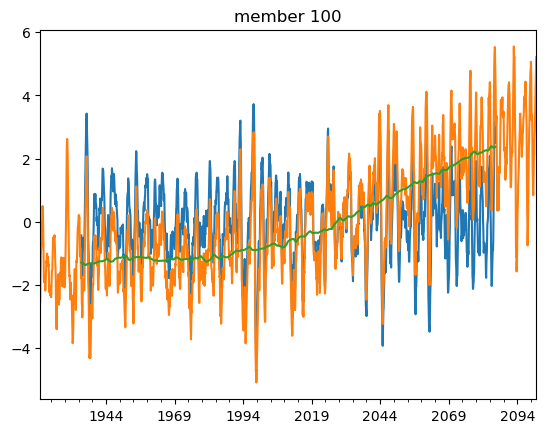

In [150]:
df_nino34_detrend[100].plot()
df_nino34[100].plot() 
df_nino34_avg[100].plot(title='member 100');

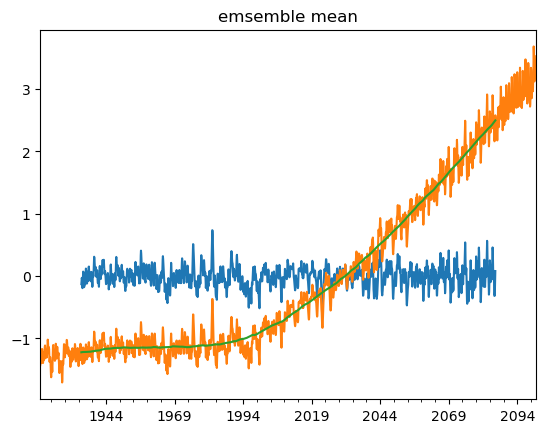

In [146]:
df_nino34_detrend.mean(axis=1).plot()
df_nino34.mean(axis=1).plot() 
df_nino34_avg.mean(axis=1).plot(title='emsemble mean');

- Create Nino DataFrame

In [21]:
# current 2003-2033 centered 2018 Future: 2055-2085  centered 2080 
# slice time series

t_delta = 0.4 #  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more
month_nino = 6

# current period centered 2018
year_cs = 2003
year_ce = 2033

# future period centered 2070
year_fs = 2055
year_fe = 2085

# create an El Nino 1, La Nino:-1, normoal:0 dataframe 
df_nino34_c_01 = create_nino_df(df_nino34_detrend, year_cs, year_ce, t_delta)
df_nino34_f_01 = create_nino_df(df_nino34_detrend, year_fs, year_fe, t_delta)
 
# array((n_mem, n_year)) of each Aug ( El Nino 1, La Nino:-1, normoal:0)
df_nino_c  = cal_nino_Aug_annual(df_nino34_c_01)
df_nino_f  = cal_nino_Aug_annual(df_nino34_f_01)

#### 1 SST composit of Auguest

In [22]:
%%time
# current period centered 2018
dec_c = ['200001-200912','201001-201412','201501-202412', '202501-203412']

# future period centered 2070
dec_f = ['205501-206412','206501-207412','207501-208412', '208501-209412']

dir_sst = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/'
n_mem = len(cesm2_1d)

# Aug of La Nina, normal, El Nino
sst_3d_c, ct_c_1d = composit_nino(dir_sst, df_nino_c, cesm2_1d, dec_c, 'SST', 8)
sst_3d_f, ct_f_1d = composit_nino(dir_sst, df_nino_f, cesm2_1d, dec_f, 'SST', 8)

# Aug mean of current and future period
sst_2d_c_aug = composit_monthly(dir_sst, cesm2_1d, dec_c, 'SST', 8)
sst_2d_f_aug = composit_monthly(dir_sst, cesm2_1d, dec_f, 'SST', 8)

CPU times: user 1min 23s, sys: 4.35 s, total: 1min 28s
Wall time: 2min 32s


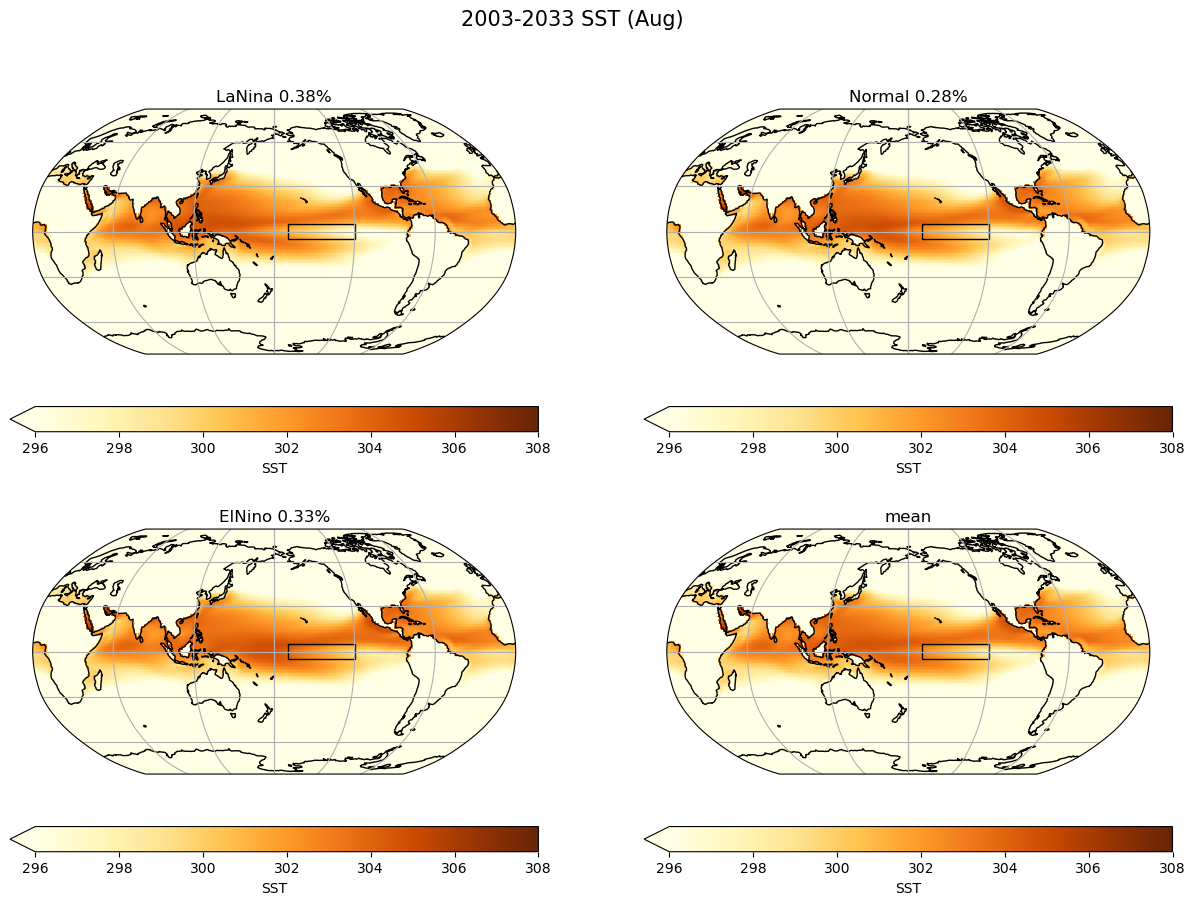

In [58]:
sst_3d_c_aug = sst_2d_c_aug.expand_dims(dim={"nino_type": 1})
sst_c = xr.concat([sst_3d_c, sst_3d_c_aug], dim="nino_type")    
plot_nino_4(sst_c, ct_c_1d.data, 296, 308, str(year_cs) + '-' + str(year_ce) + ' SST (Aug)', 'YlOrBr', 'global')   

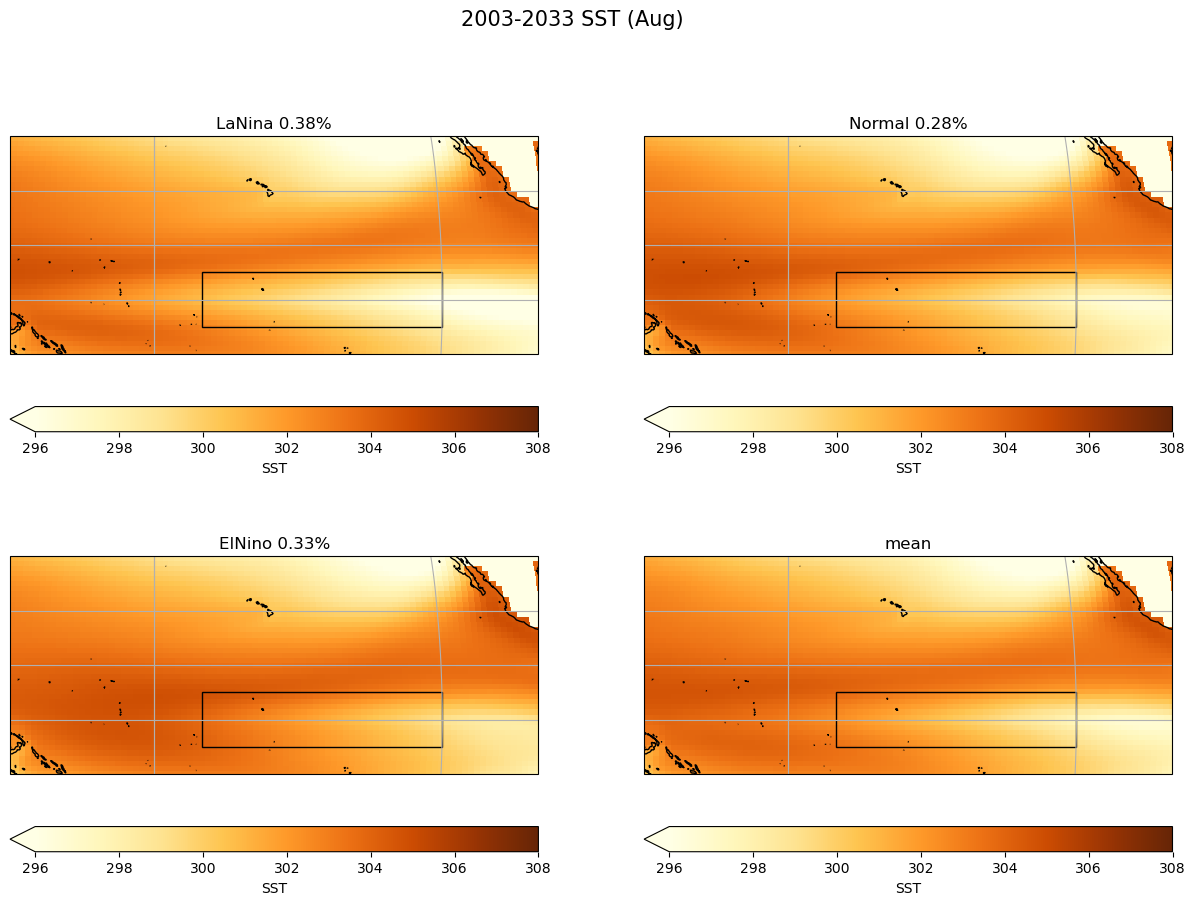

In [56]:
plot_nino_4(sst_c, ct_c_1d.data, 296, 308, str(year_cs) + '-' + str(year_ce) + ' SST (Aug)', 'YlOrBr', 'zoom')   

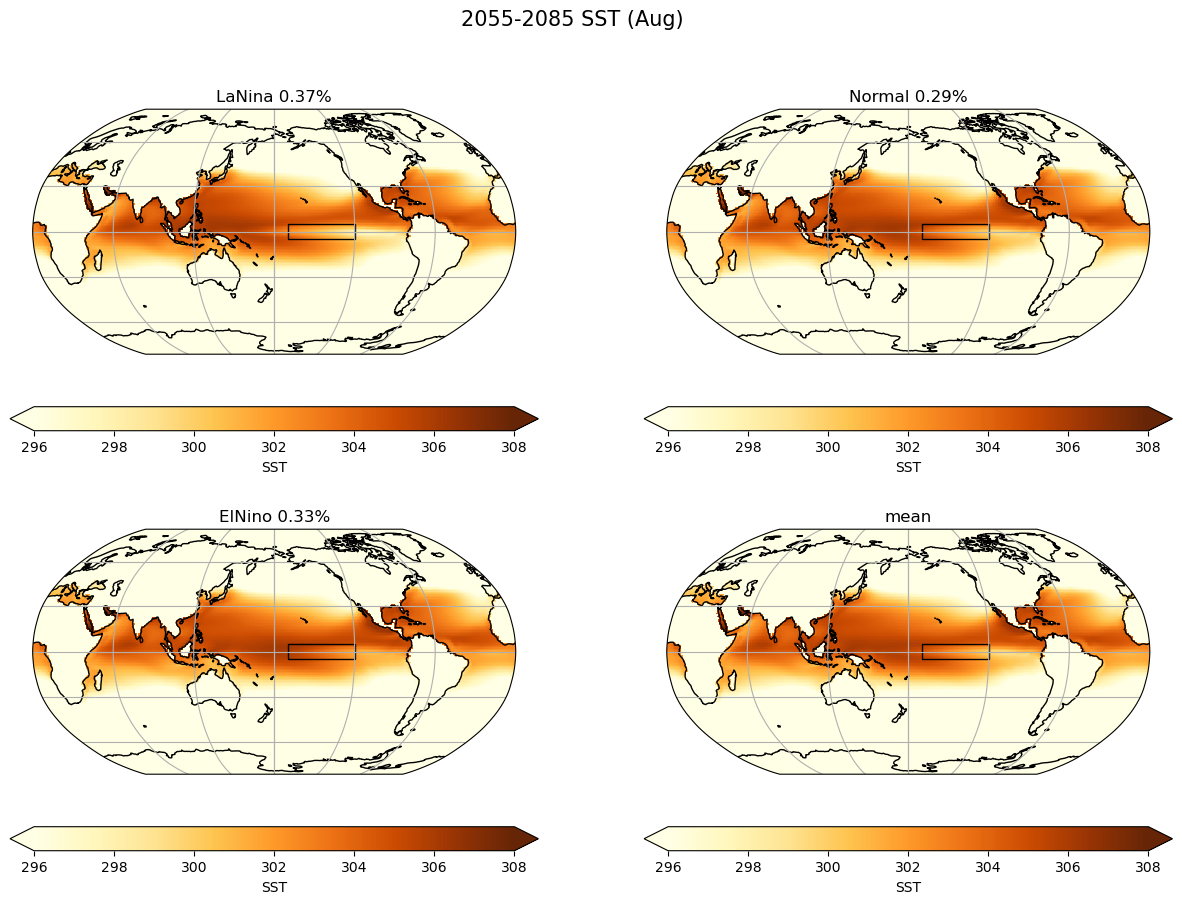

In [59]:
sst_3d_f_aug = sst_2d_f_aug.expand_dims(dim={"nino_type": 1})
sst_f = xr.concat([sst_3d_f, sst_3d_f_aug], dim="nino_type")    
plot_nino_4(sst_f, ct_f_1d.data, 296, 308, str(year_fs) + '-' + str(year_fe) + ' SST (Aug)', 'YlOrBr', 'global') 


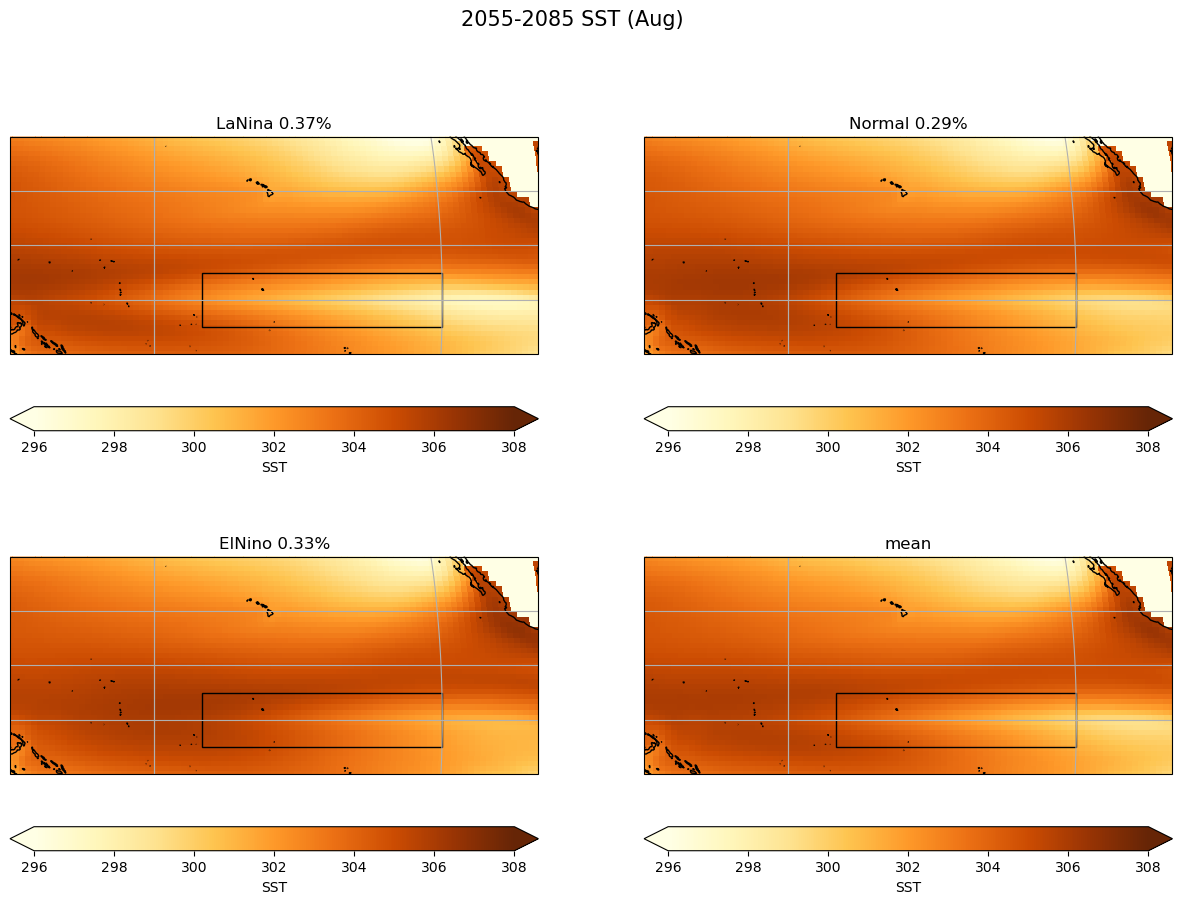

In [60]:
plot_nino_4(sst_f, ct_f_1d.data, 296, 308, str(year_fs) + '-' + str(year_fe) + ' SST (Aug)', 'YlOrBr', 'zoomIn') 

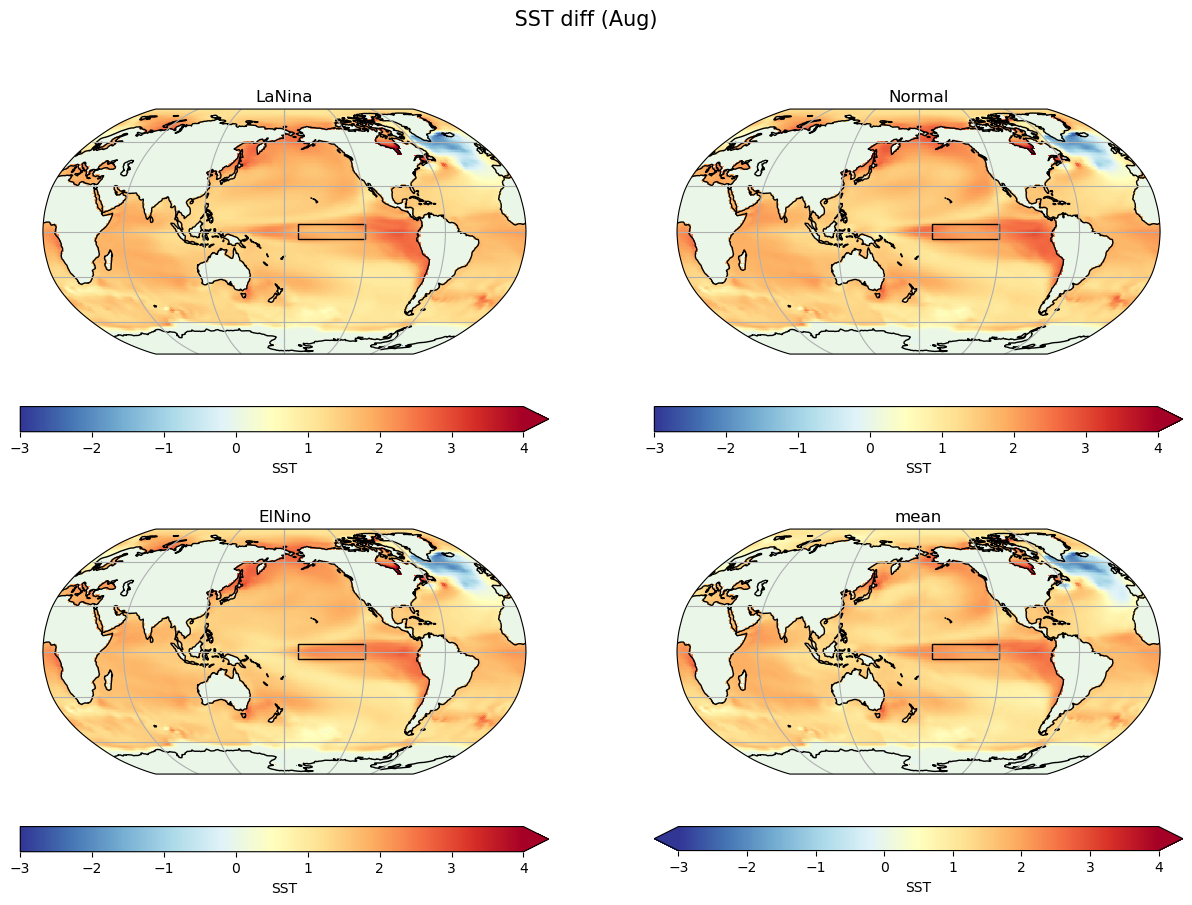

In [61]:
plot_nino_4(sst_f-sst_c, np.zeros((3)), -3, 4, ' SST diff (Aug)', 'RdYlBu_r', 'global')  

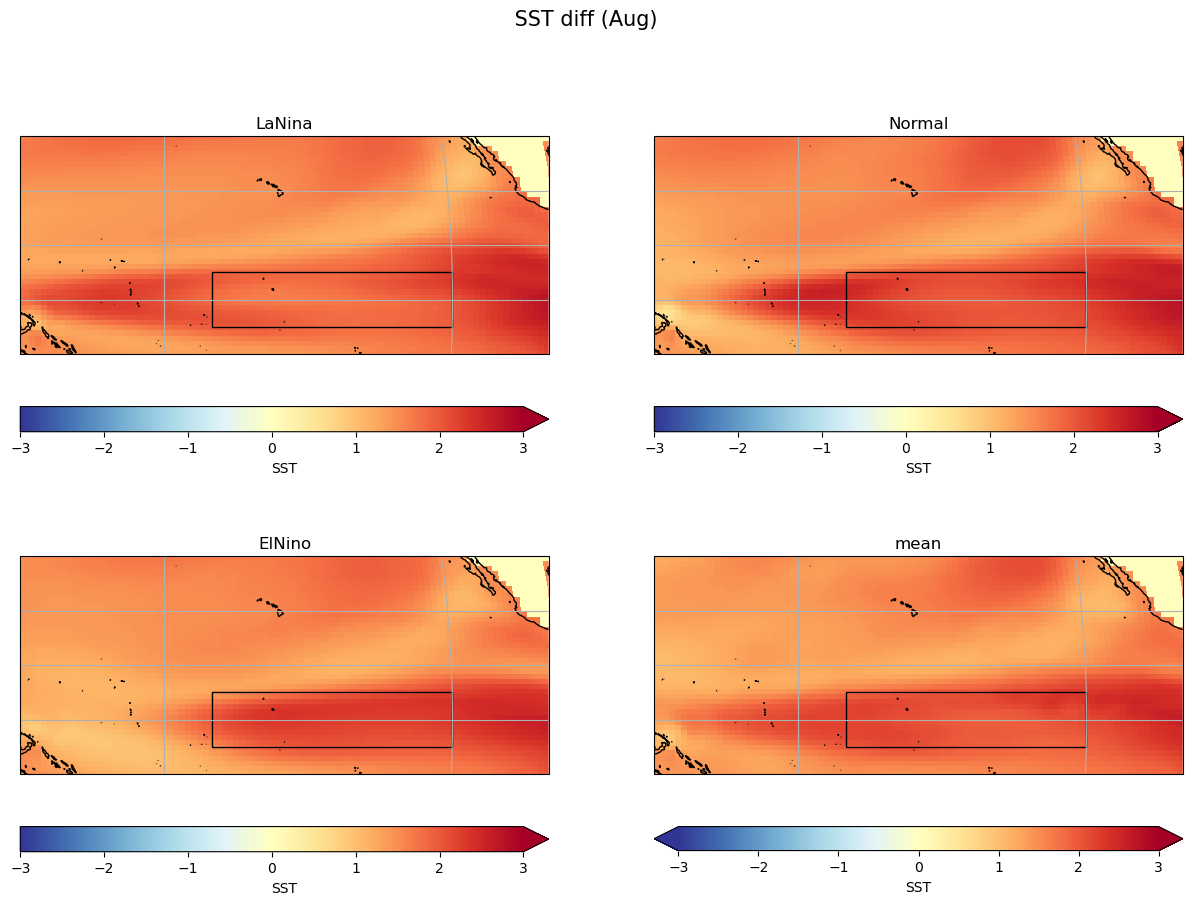

In [63]:
plot_nino_4(sst_f-sst_c, np.zeros((3)), -3, 3, ' SST diff (Aug)', 'RdYlBu_r', 'zoomIn')  

#### The SST difference between Future La Nina/El Nino and current average

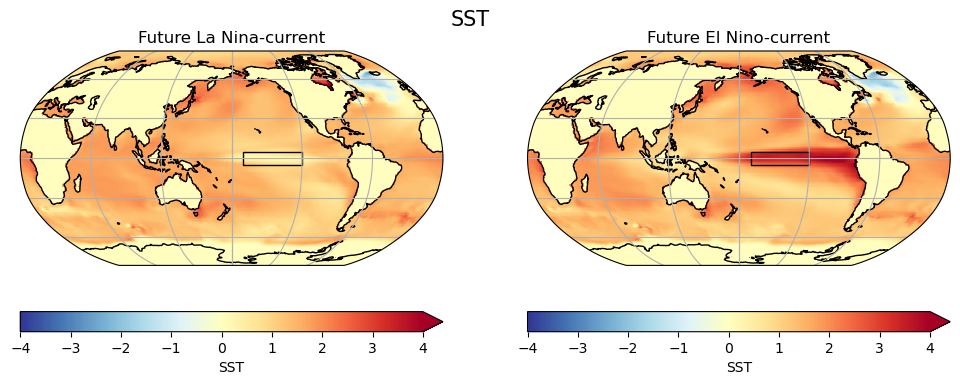

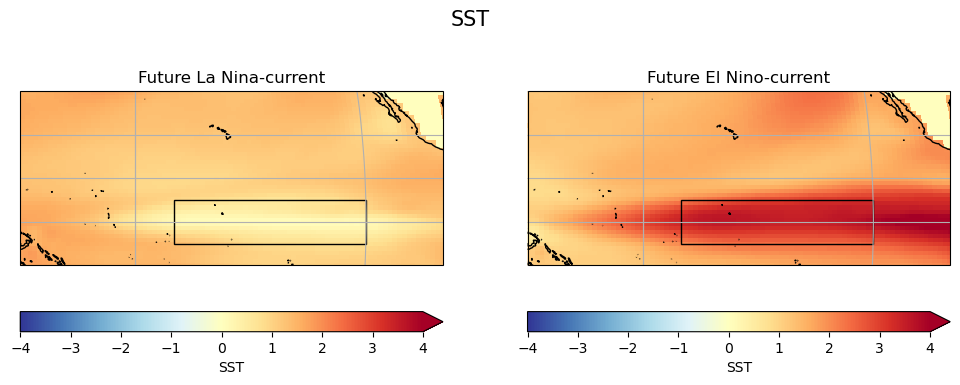

In [51]:
sst_fd = xr.concat([sst_3d_f[0]-sst_2d_c_aug, sst_3d_f[2]-sst_2d_c_aug], dim="nino_type")    
plot_nino_2(sst_fd, -4, 4, 'SST', 'RdYlBu_r', 'global')
plot_nino_2(sst_fd, -4, 4, 'SST', 'RdYlBu_r', 'zoomIn')

#### 2 U500/V500 from daily data

In [64]:
# CESM2 ensemble members
# collect 100 members in CVDP dataset and sorted by name:
flnm_1d = sorted(glob.glob("/glade/derecho/scratch/mingge/LENS2/cesm-lens_1920-2100.cvdp_data/CESM2-LENS_1*cvdp_data.1920-2100.nc"))
n_mem = len(flnm_1d)
flnm_list = []

cesm2_1d = []
for flnm in flnm_1d:
    cesm2_1d.append(flnm[77:85])

# current period centered 2018
dec_c = ['20000101-20091231','20100101-20141231','20150101-20241231', '20250101-20341231']

# future period centered 2070
dec_f = ['20550101-20641231','20650101-20741231','20750101-20841231', '20850101-20941231']

n_dec = len(dec_c)

In [65]:
%%time  

dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
dir_var = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/U500/'
 
u500_c, ct_c_1d = composit_nino_daily(dir_o, dir_var, df_nino_c, cesm2_1d, dec_c, 'U500',8)
u500_f, ct_f_1d = composit_nino_daily(dir_o, dir_var, df_nino_f, cesm2_1d, dec_f, 'U500',8)
u500_c_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_c, 'U500', 8)
u500_f_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_f, 'U500', 8)

dir_var = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/V500/'
v500_c, ct_c_1d = composit_nino_daily(dir_o, dir_var, df_nino_c, cesm2_1d, dec_c, 'V500',8)
v500_f, ct_f_1d = composit_nino_daily(dir_o, dir_var, df_nino_f, cesm2_1d, dec_f, 'V500',8)

v500_c_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_c, 'V500', 8)
v500_f_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_f, 'V500', 8)


/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U500_2003-2033_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U500_2003-2033_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U500_2055-2085_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U500_2055-2085_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V500_2003-2033_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V500_2003-2033_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V500_2055-2085_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V500_2055-2085_nino_aug.nc  exist
CPU times: user 5.29 s, sys: 364 ms, total: 5.65 s
Wall time: 22.4 s


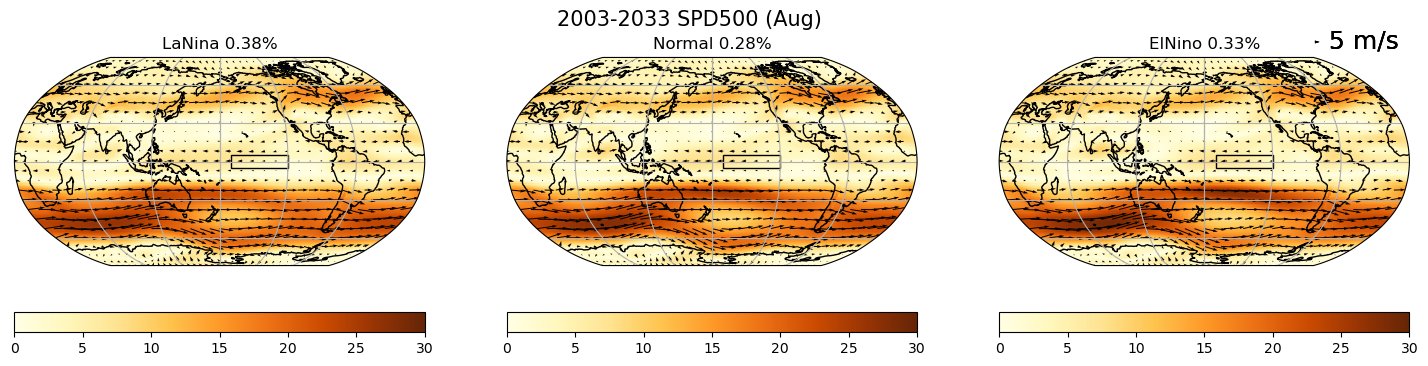

In [81]:
spd500_c = u500_c.copy()
spd500_c = np.sqrt(u500_c**2 + v500_c**2)
plot_nino_wind3(spd500_c, u500_c.data, v500_c.data, ct_c_1d.data, 0, 30, str(year_cs) + '-' + str(year_ce) + ' SPD500 (Aug)', 'YlOrBr', 'global') 

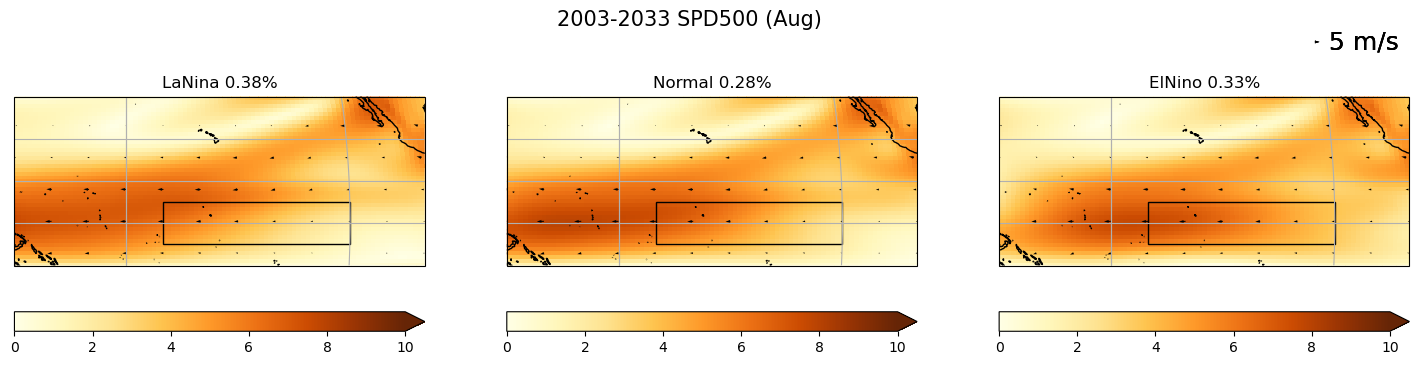

In [83]:
plot_nino_wind3(spd500_c, u500_c.data, v500_c.data, ct_c_1d.data, 0, 10, str(year_cs) + '-' + str(year_ce) + ' SPD500 (Aug)', 'YlOrBr', 'zoomIn') 

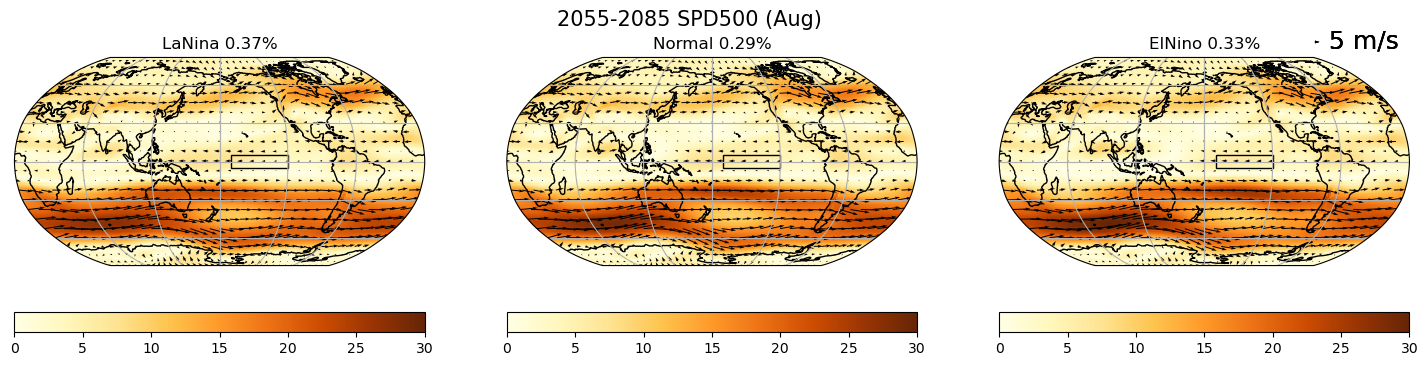

In [84]:
spd500_f = u500_c.copy()
spd500_f = np.sqrt(u500_f**2 + v500_f**2)
plot_nino_wind3(spd500_f, u500_f.data, v500_f.data, ct_f_1d.data, 0, 30, str(year_fs) + '-' + str(year_fe) + ' SPD500 (Aug)', 'YlOrBr', 'global') 

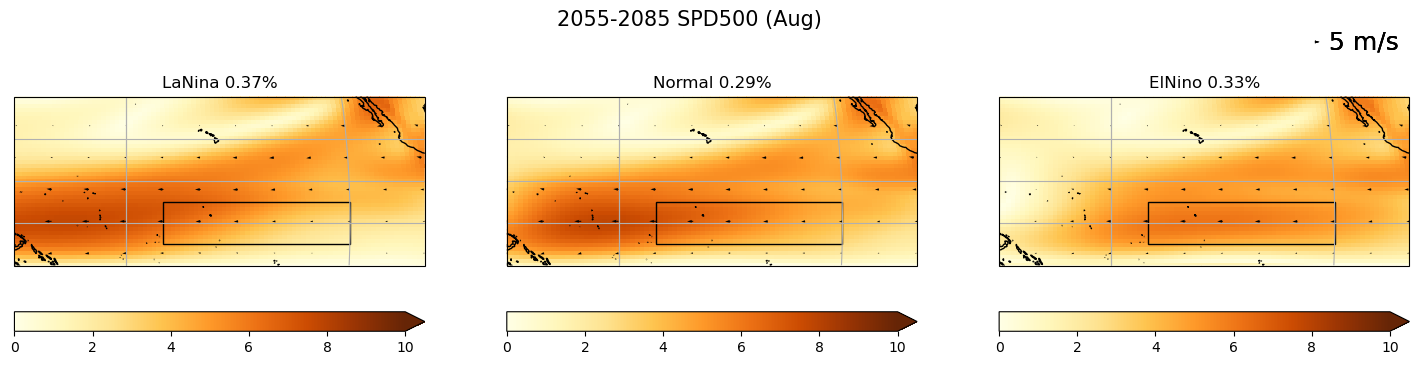

In [85]:
plot_nino_wind3(spd500_f, u500_f.data, v500_f.data, ct_f_1d.data, 0, 10, str(year_fs) + '-' + str(year_fe) + ' SPD500 (Aug)', 'YlOrBr', 'zoomIn') 

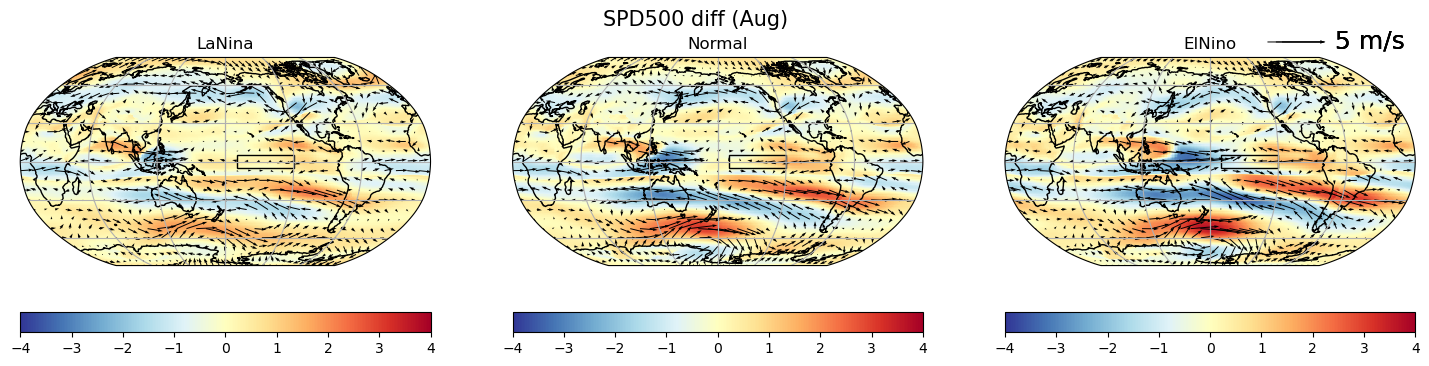

In [86]:
plot_nino_wind3(spd500_f-spd500_c, (u500_f-u500_c).data, (v500_f-v500_c).data, np.zeros((3)), -4, 4,  'SPD500 diff (Aug)', 'RdYlBu_r', 'global')


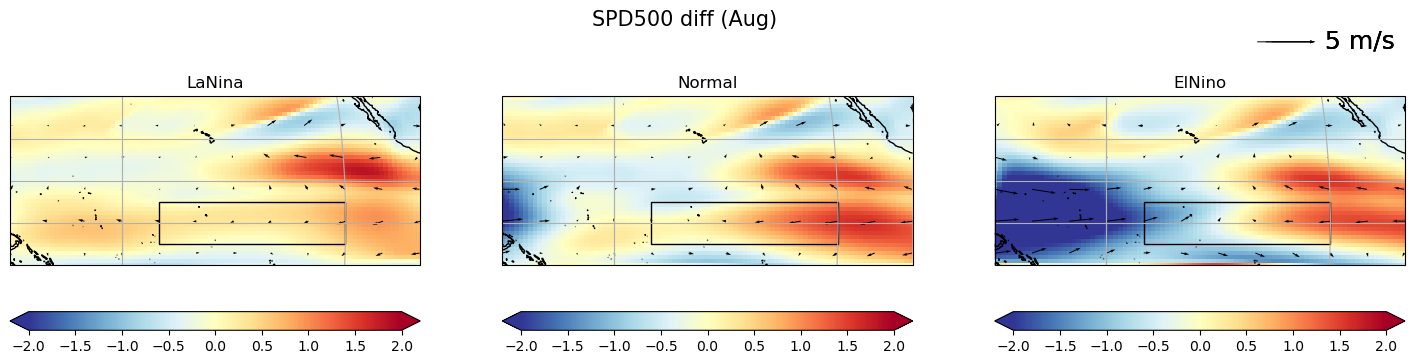

In [87]:
plot_nino_wind3(spd500_f-spd500_c, (u500_f-u500_c).data, (v500_f-v500_c).data, np.zeros((3)), -2, 2,  'SPD500 diff (Aug)', 'RdYlBu_r', 'zoomIn')

#### 500 hPa Wind difference between Future La Nina/El Nino and current average

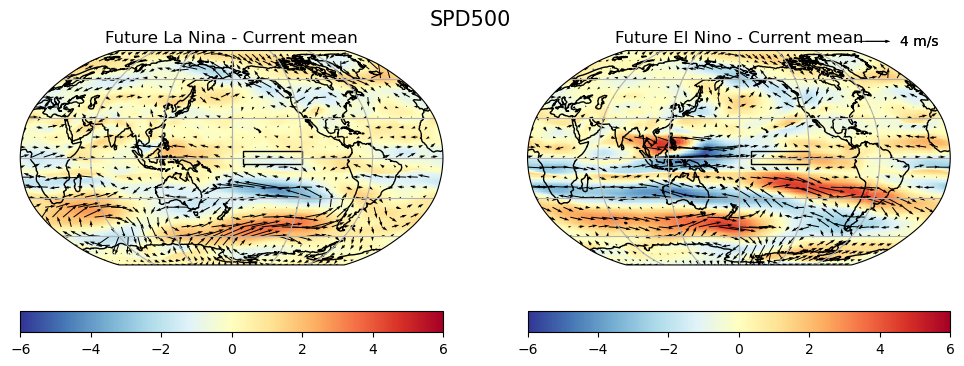

In [91]:
spd500_c_aug = u500_c.copy()
spd500_c_aug = np.sqrt(u500_c_aug**2 + v500_c_aug**2)

spd500_fd = xr.concat([spd500_f[0]-spd500_c_aug, spd500_f[2]-spd500_c_aug], dim="nino_type")    

u500_fd = xr.concat([u500_f[0]-u500_c_aug, u500_f[2]-u500_c_aug], dim="nino_type")   
v500_fd = xr.concat([v500_f[0]-v500_c_aug, v500_f[2]-v500_c_aug], dim="nino_type")   

title_sub = ['Future La Nina - Current mean', 'Future El Nino - Current mean']
plot_nino_wind2(spd500_fd, u500_fd.data, v500_fd.data, np.zeros((3)), -6, 6, 'SPD500', title_sub, 'RdYlBu_r', 'global')


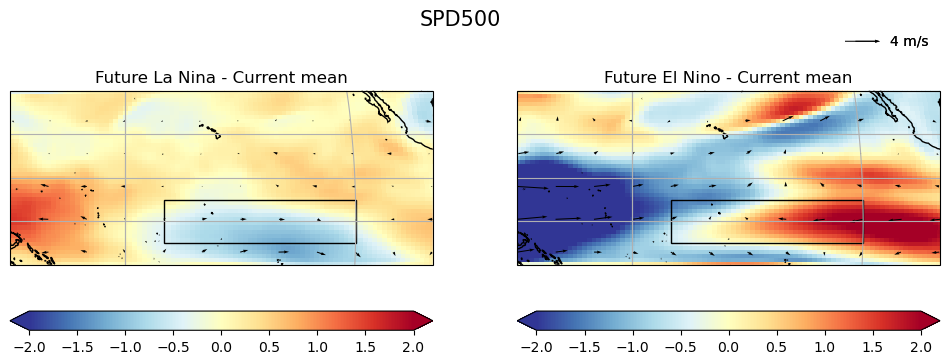

In [90]:
title_sub = ['Future La Nina - Current mean', 'Future El Nino - Current mean']
plot_nino_wind2(spd500_fd, u500_fd.data, v500_fd.data, np.zeros((3)), -2, 2, 'SPD500', title_sub, 'RdYlBu_r', 'zoomIn')

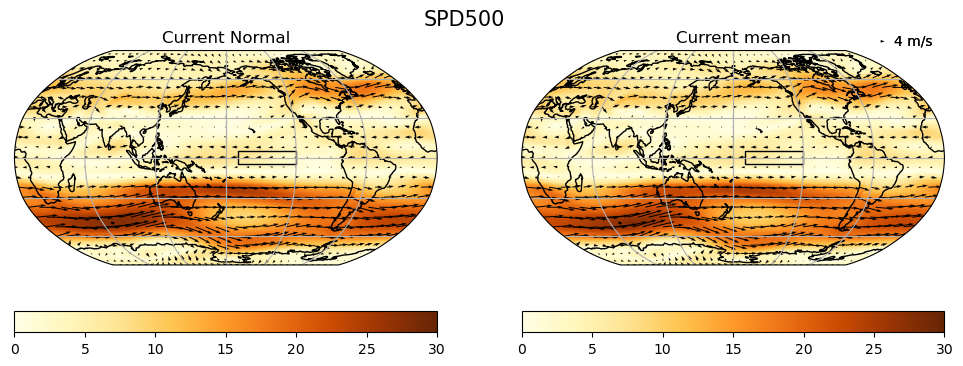

In [94]:
spd500_2 = xr.concat([spd500_c[1],  spd500_c_aug], dim="nino_type")    
u500_2   = xr.concat([u500_c[1],    u500_c_aug], dim="nino_type")   
v500_2   = xr.concat([v500_c[1],    v500_c_aug], dim="nino_type")   

title_sub = ['Current Normal', 'Current mean']
plot_nino_wind2(spd500_2, u500_2.data, v500_2.data, np.zeros((3)), 0, 30, 'SPD500', title_sub, 'YlOrBr', 'global')

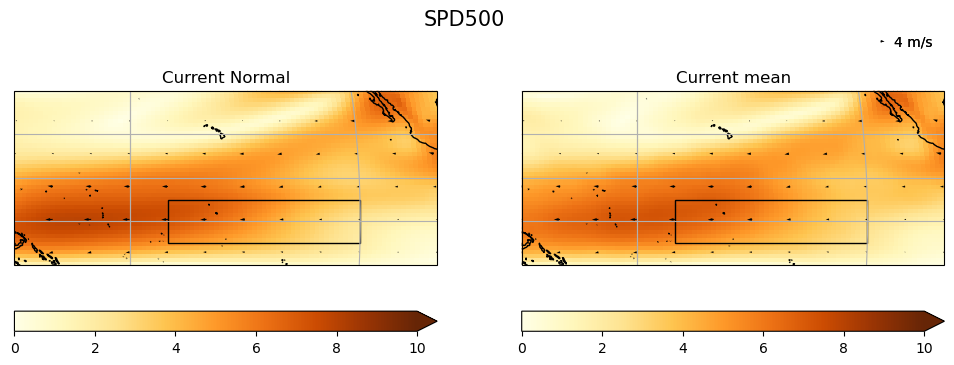

In [96]:
plot_nino_wind2(spd500_2, u500_2.data, v500_2.data, np.zeros((3)), 0, 10, 'SPD500', title_sub, 'YlOrBr', 'zoomIn')

In [97]:
dir_var = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/U200/'
u200_c, ct_c_1d = composit_nino_daily(dir_o, dir_var, df_nino_c, cesm2_1d, dec_c, 'U200',8)
u200_f, ct_f_1d = composit_nino_daily(dir_o, dir_var, df_nino_f, cesm2_1d, dec_f, 'U200',8)
u200_c_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_c, 'U200', 8)
u200_f_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_f, 'U200', 8)

dir_var = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/V200/'
v200_c, ct_c_1d = composit_nino_daily(dir_o, dir_var, df_nino_c, cesm2_1d, dec_c, 'V200',8)
v200_f, ct_f_1d = composit_nino_daily(dir_o, dir_var, df_nino_f, cesm2_1d, dec_f, 'V200',8)
v200_c_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_c, 'V200', 8)
v200_f_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_f, 'V200', 8)


/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U200_2003-2033_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U200_2003-2033_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U200_2055-2085_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U200_2055-2085_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V200_2003-2033_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V200_2003-2033_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V200_2055-2085_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V200_2055-2085_nino_aug.nc  exist


In [98]:
dir_var = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/U850/'
u850_c, ct_c_1d = composit_nino_daily(dir_o, dir_var, df_nino_c, cesm2_1d, dec_c, 'U850', 8)
u850_f, ct_f_1d = composit_nino_daily(dir_o, dir_var, df_nino_f, cesm2_1d, dec_f, 'U850', 8)
u850_c_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_c, 'U850', 8)
u850_f_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_f, 'U850', 8)

dir_var = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/V850/'
v850_c, ct_c_1d = composit_nino_daily(dir_o, dir_var, df_nino_c, cesm2_1d, dec_c, 'V850', 8)
v850_f, ct_f_1d = composit_nino_daily(dir_o, dir_var, df_nino_f, cesm2_1d, dec_f, 'V850', 8)
v850_c_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_c, 'V850', 8)
v850_f_aug = composit_monthlyFromDaily_lens2(dir_var, cesm2_1d, dec_f, 'V850', 8)


/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U850_2003-2033_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U850_2003-2033_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U850_2055-2085_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/U850_2055-2085_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V850_2003-2033_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V850_2003-2033_nino_aug.nc  exist
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V850_2055-2085_nino_aug.nc
/glade/campaign/mmm/c3we/mingge/DOD/LENS2/V850_2055-2085_nino_aug.nc  exist


- wind shear

/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


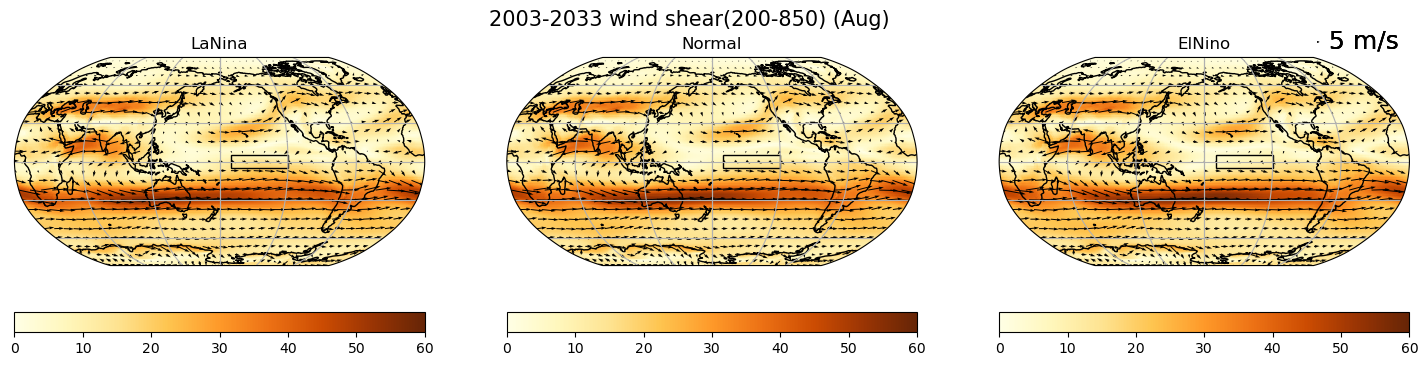

In [103]:
shear_c = u200_c.copy()
shear_c = np.sqrt((u200_c-u850_c)**2 + (v200_c-v850_c)**2)  
plot_nino_wind3(shear_c, (u200_c-u850_c).data, (v200_c-v850_c).data, np.zeros((3)), 0, 60, str(year_cs) + '-' + str(year_ce) + ' wind shear(200-850) (Aug)', 'YlOrBr', 'global')

/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


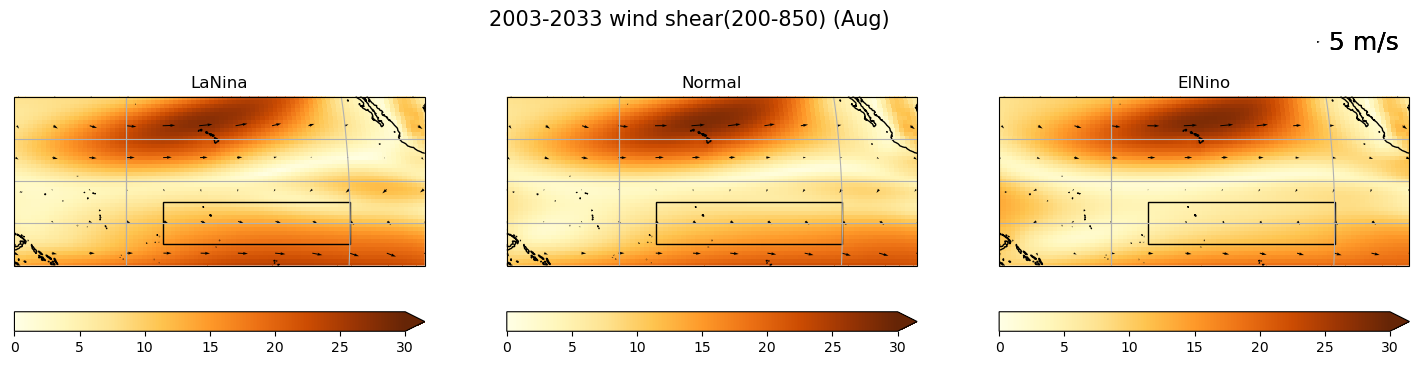

In [102]:
plot_nino_wind3(shear_c, (u200_c-u850_c).data, (v200_c-v850_c).data, np.zeros((3)), 0, 30, str(year_cs) + '-' + str(year_ce) + ' wind shear(200-850) (Aug)', 'YlOrBr', 'zoomIn')

/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


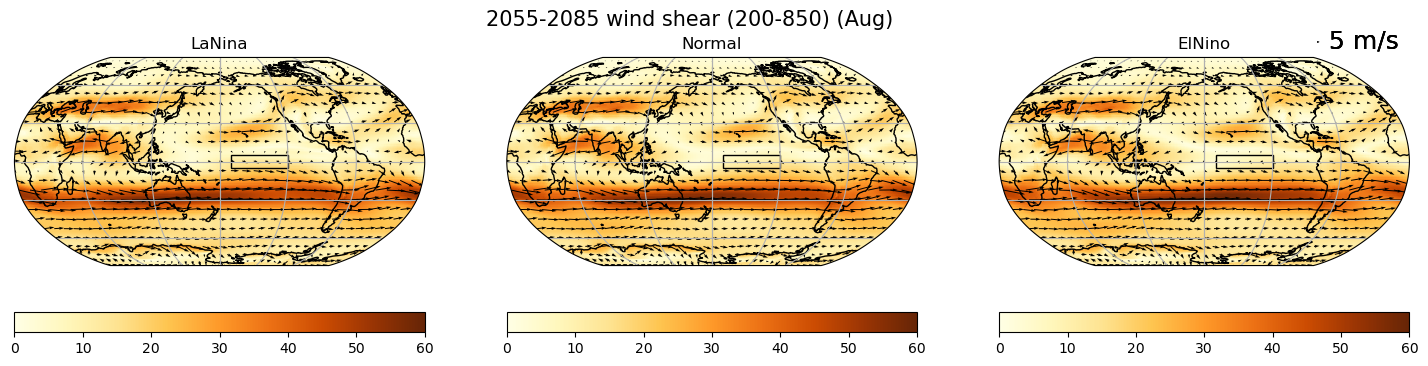

In [104]:
shear_f = u200_c.copy()
shear_f = np.sqrt((u200_f-u850_f)**2 + (v200_f-v850_f)**2)
plot_nino_wind3(shear_f, (u200_f-u850_f).data, (v200_f-v850_f).data, np.zeros((3)), 0, 60, str(year_fs) + '-' + str(year_fe) + ' wind shear (200-850) (Aug)', 'YlOrBr', 'global')


/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


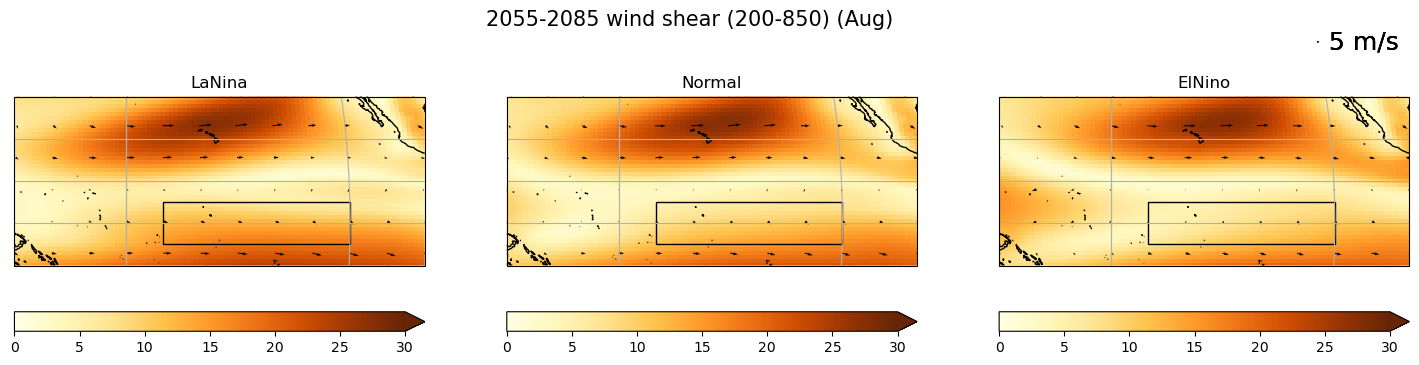

In [106]:
plot_nino_wind3(shear_f, (u200_f-u850_f).data, (v200_f-v850_f).data, np.zeros((3)), 0, 30, str(year_fs) + '-' + str(year_fe) + ' wind shear (200-850) (Aug)', 'YlOrBr', 'zoomIn')


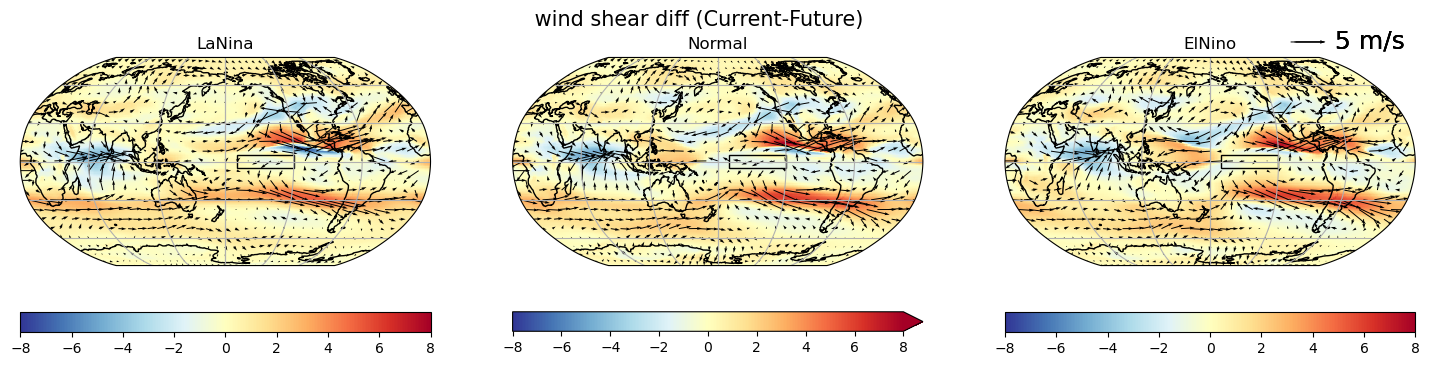

In [111]:
shear_d = shear_f-shear_c
shear_du = (u200_f-u850_f) - (u200_c-u850_c)
shear_dv = (v200_f-v850_f) - (v200_c-v850_c)
plot_nino_wind3(shear_d, shear_du.data, shear_dv.data, np.zeros((3)), -8, 8, ' wind shear diff (Current-Future)', 'RdYlBu_r', 'global'); 

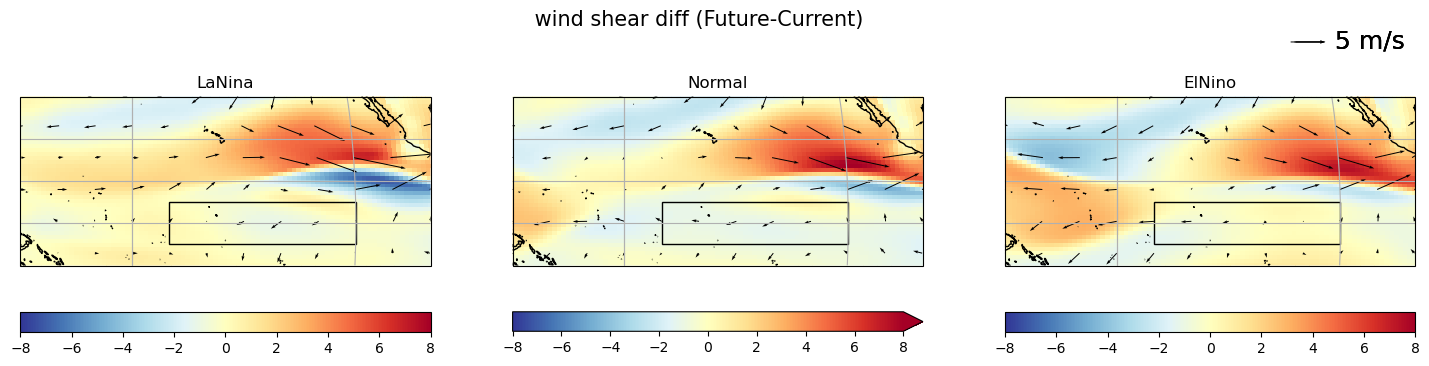

In [110]:
plot_nino_wind3(shear_d, shear_du.data, shear_dv.data, np.zeros((3)), -8, 8, ' wind shear diff (Future-Current)', 'RdYlBu_r', 'zoomIn'); 

#### Wind shear difference between Future La Nina/El Nino and current average

/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


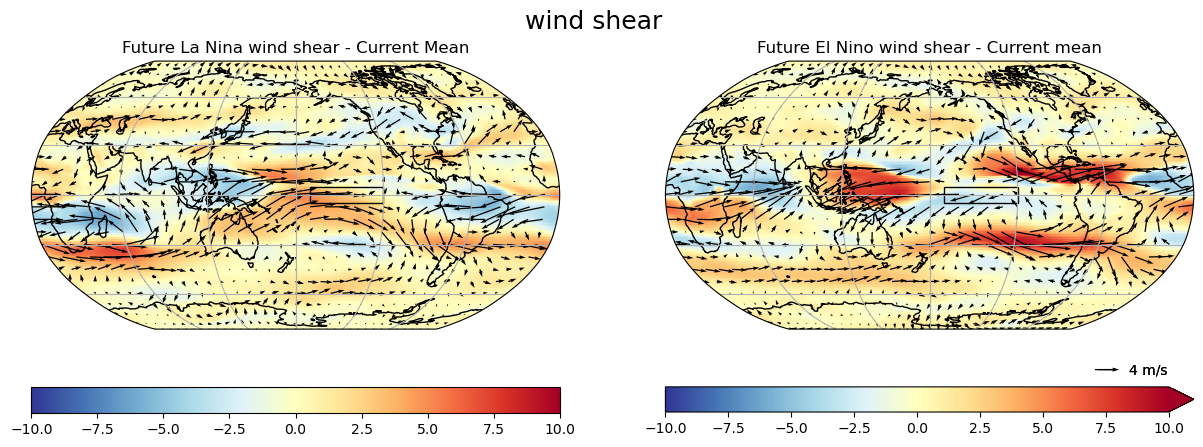

In [134]:
title_sub = ['Future La Nina wind shear - Current Mean', 'Future El Nino wind shear - Current mean']
shear_c_aug = u200_c.copy()
shear_c_aug = np.sqrt((u200_c_aug-u850_c_aug)**2 + (v200_c_aug-v850_c_aug)**2)
 
shear_du1 = (u200_f[0] - u850_f[0]) - (u200_c_aug - u850_c_aug)
shear_dv1 = (v200_f[0] - v850_f[0]) - (v200_c_aug - v850_c_aug)
shear_du2 = (u200_f[2] - u850_f[2]) - (u200_c_aug - u850_c_aug)
shear_dv2 = (v200_f[2] - v850_f[2]) - (v200_c_aug - v850_c_aug)
 
shear_dspd = xr.concat([shear_f[0]-shear_c_aug, shear_f[2]- shear_c_aug], dim="nino_type")    
shear_du   = xr.concat([shear_du1, shear_du2], dim="nino_type")    
shear_dv   = xr.concat([shear_dv1, shear_dv2], dim="nino_type")  

plot_nino_wind2(shear_dspd, shear_du.data, shear_dv.data, np.zeros((3)), -10, 10,  'wind shear', title_sub, 'RdYlBu_r', 'global')


/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


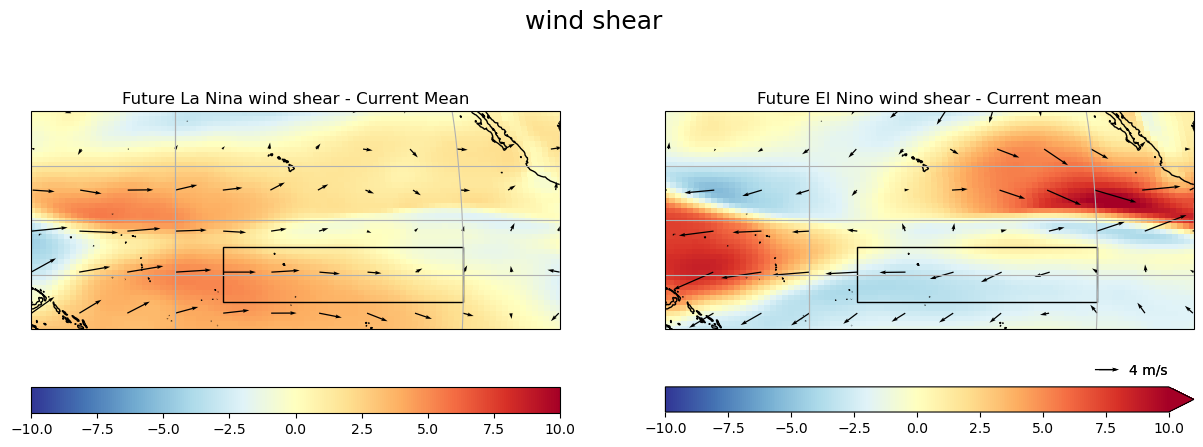

In [135]:
plot_nino_wind2(shear_dspd, shear_du.data, shear_dv.data, np.zeros((3)), -10, 10,  'wind shear', title_sub, 'RdYlBu_r', 'zoomIn')

/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


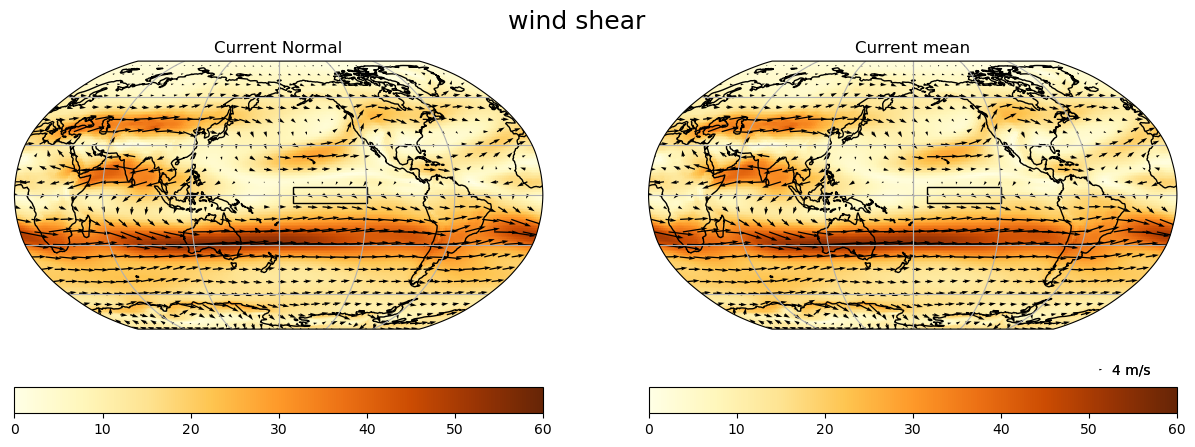

In [142]:
title_sub = ['Current Normal', 'Current mean']
shear_2   = xr.concat([shear_c[1],  shear_c_aug], dim="nino_type")    
shearu_2  = xr.concat([u200_c[1]-u850_c[1], u200_c_aug - u850_c_aug], dim="nino_type")   
shearv_2  = xr.concat([v200_c[1]-v850_c[1], v200_c_aug - v850_c_aug], dim="nino_type")   

#plot_nino_wind2(spd500_2, u500_2.data, v500_2.data, np.zeros((3)), 0, 30, 'SPD500', title_sub, 'YlOrBr', 'global')
plot_nino_wind2(shear_2, shearu_2.data, shearv_2.data, np.zeros((3)), 0, 60,  'wind shear', title_sub, 'YlOrBr','global')

/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/glade/u/home/mingge/miniforge3/envs/casper_2023/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


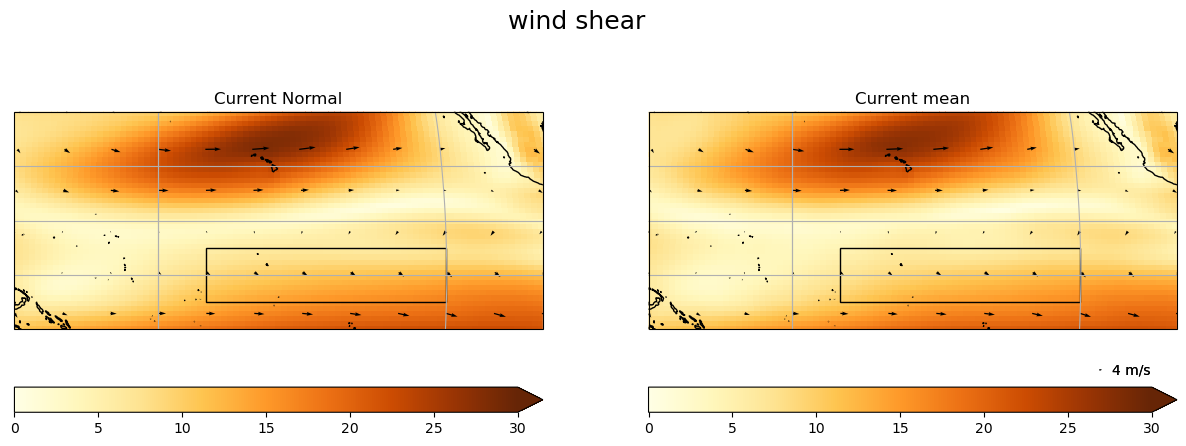

In [144]:
plot_nino_wind2(shear_2, shearu_2.data, shearv_2.data, np.zeros((3)), 0, 30,  'wind shear', title_sub, 'YlOrBr','zoomIn')

In [44]:
#df_nino_c[1]